In [ ]:
"""
Day 58: Skyfield学習用スクリプト
ターミナルで実行して惑星の位置計算を学習する
#Skyfieldのトップページにあるプログラムを実行してみる
Skyfield: https://rhodesmill.org/skyfield/

参考にした記事:
note 天文と気象（とその他いろいろ）「Skyfieldを使いながら、天球座標系を学ぶ」
https://note.com/symmetrybreaking/n/n74dbbf578fb0
"""

In [ ]:
from skyfield.api import load,wgs84

# 火星の天空上の位置、地心座標
# Create the timescale and ask the current time.
ts = load.timescale()
t = ts.now()

# Load the JPL ephemeris DE421 (covers 1900-2050).
planets = load('de421.bsp')
earth,mars = planets['earth'], planets['mars']

# What's the position of Mars, viewed from earth?
astrometric = earth.at(t).observe(mars)
ra, dec, distance = astrometric.radec()

# 赤経（Right Ascension）と赤緯（Declination）と天文単位（au）
print(ra)
print(dec)
print(distance)

18h 57m 40.35s
-23deg 40' 35.9"
2.40981 au


In [ ]:
# 天文単位（au）の型を確認してみる
print(type(distance))

<class 'skyfield.units.Distance'>


In [12]:
# kmに変換
km = distance.au * 149597870.7
print(f"{km} km")

360502751.1170485 km


In [13]:
# 月との距離を出してみる
moon = planets['moon']
astrometric_moon = earth.at(t).observe(moon)
ra_moon,dec_moon,distance_moon = astrometric_moon.radec()

print(ra_moon)
print(dec_moon)
print(distance_moon)

km_moon = distance_moon.au * 149597870.7
print(f"{km_moon} km")

05h 28m 46.79s
+28deg 11' 24.2"
0.0024091 au
360396.10112219566 km


In [14]:
# 火星と月の距離比較
print(f"火星までの距離は月までの距離の{km/km_moon}倍です")

火星までの距離は月までの距離の1000.2959243857543倍です


In [ ]:
# 広島から火星はどの方向に見えるか
# boston = earth + wgs84.latlon(42.3583 * N, 71.0636 * W)　日本ではNとWは不要。大西洋側で使う。

hiroshima = earth + wgs84.latlon(34.3853, 132.4553)
astrometric = hiroshima.at(t).observe(mars)
alt,az,d = astrometric.apparent().altaz()
print(alt)
print(az)

print(f"火星は今、広島の空の高度{alt}、方位角{az}の方向にあります")

"""
☆note☆
角度
自分の手の分度器＝拳の長さ/目から拳の先までの長さ * 57.3
拳ひとつ分は約10度になる。
マイナスの場合は、地平線よりも下にあることを示す。

方位
方位は北を0度として時計回りに数えていく。東が90度、南が180度、西が270度となる。
"""

-78deg 11' 46.3"
334deg 30' 09.8"
火星は今、広島の空の高度-78deg 11' 46.3"、方位角334deg 30' 09.8"の方向にあります


'\n☆note☆\n角度\n自分の手の分度器＝拳の長さ/目から拳の先までの長さ * 57.3\n拳ひとつ分は約10度になる。\nマイナスの場合は、地平線よりも下にあることを示す。\n\n方位\n方位は北を0度として時計回りに数えていく。東が90度、南が180度、西が270度となる。\n'

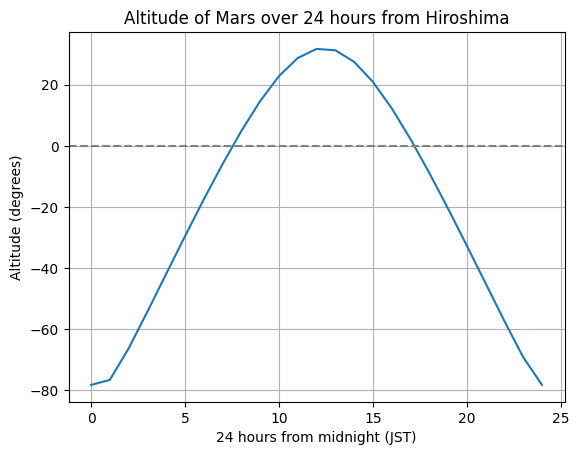

In [26]:
# 高度の変化グラフの作成「いつ昇っていつ沈むか」
import matplotlib.pyplot as plt
from datetime import datetime,timedelta,timezone

# 24時間分の高度を計算
times = []
alts = []

# 日本時間（JST = UTC+9）
JST = timezone(timedelta(hours=9))
now = datetime.now(JST)
start = datetime(now.year, now.month, now.day, 0, 0, 0, tzinfo=JST)

for i in range(25):
    #  今日の0時から開始して、1時間ごとに計算
    time = start + timedelta(hours=i)
    t = ts.from_datetime(time)

    #　広島からの視点で火星を観測
    obs = hiroshima.at(t).observe(mars).apparent()
    alt,az,d = obs.altaz()

    alts.append(alt.degrees)
    times.append(i) # 0時間後から24時間後  ☆note☆ i=0から始まるので25回ループして24時間分になる

# グラフの描画
plt.plot(times,alts)
plt.xlabel("24 hours from midnight (JST)")
plt.ylabel("Altitude (degrees)")
plt.title("Altitude of Mars over 24 hours from Hiroshima") 
plt.grid()
plt.axhline(0, color='gray', linestyle='--')  # 地平線
plt.show()


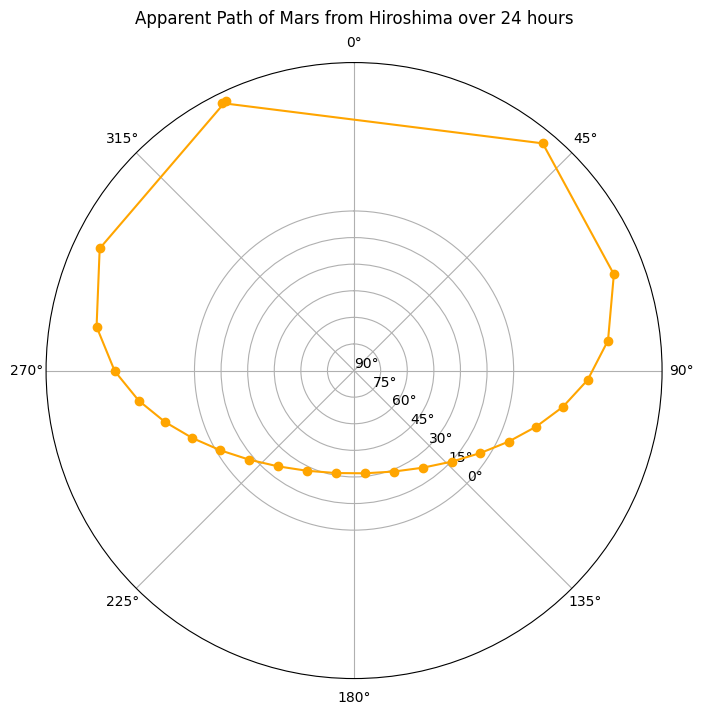

In [ ]:
# 火星の通り道方位変化を立体的に表してみる「いつどの方向にあるか」
import numpy as np
import matplotlib.pyplot as plt

"""
データを変換する。方位をラジアンに、高度を中心からの距離に変換する。
方位(az)はそのままにして、高度(alt)は90-altとすることで中心からの距離にする。
東90°が昇る時、西270°が沈む時になる。
"""

azs = []
alts = []

for i in range(25):
    time = start + timedelta(hours=i)
    t = ts.from_datetime(time)
    # 広島から見た火星を観測
    obs = hiroshima.at(t).observe(mars).apparent()
    alt, az, d = obs.altaz()
    
    # 数値をリストに追加
    alts.append(alt.degrees)
    azs.append(az.degrees)

# 変換
az_rad = [np.radians(az) for az in azs]
alt_distance = [90 - alt for alt in alts]

# 極座標グラフの描画
plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')

# 火星の通りをプロット
ax.plot(az_rad, alt_distance, marker='o', linestyle='-', color='orange')

# グラフの設定
ax.set_theta_zero_location('N')  # 0度を北に設定
ax.set_theta_direction(-1)  # 時計回りに方位を増加
ax.set_rlabel_position(135)  # 半径ラベルの位置を調整
ax.set_title("Apparent Path of Mars from Hiroshima over 24 hours", va='bottom')

# 高度表示のカスタマイズ
ax.set_yticks([0, 15, 30, 45, 60, 75, 90])
ax.set_yticklabels(['90°', '75°', '60°', '45°', '30°', '15°', '0°'])

plt.show()


In [ ]:
"""
3Dで自分の位置から空を見上げたような表示にするために、0~360°ではなく、ラジアン単位に変換する必要がある。
ラジアン単位とは、数学的に計算を行うための単位で、これを用いて変換することで地平線が0，天頂が1という座標（高さ）として扱えるようになる。
半径を1とした、空のドームを想定する場合の計算方法

3D座標（x,y,z）の計算方法 
1. 高度（Altitude）を高さ（z）に変換する
    高度をラジアンに直してsinを計算する。これによって地平線0°、天頂90°が0から1の数値に変換される。
    Z = sin(高度_rad)

2. 方位（Azimuth）を水平位置x,y座標に変換する
    方位角（どの方角か）と、高度（どれだけ中心に寄るか）を組み合わせて計算する。
    真上（Z=1)にいくほど、XとYは0に近づき中心へ寄っていく。
    
    X = cos(高度_rad) * sin(方位_rad)
    Y = cos(高度_rad) * cos(方位_rad)

半径を1としたドームの計算方法まとめ
    高度（Alt）をラジアンに変換: alt_rad = np.radians(alt)
    高さ（Z）を出す: Z = np.sin(alt_rad) （これで地平線0〜天頂1に収まる）
    横の広がり（r）を出す: r = np.cos(alt_rad) （真上にいくほど0に近づく半径。天頂1〜地平線0に収まる）
　　東西（X）を出す: X = r * np.sin(az_rad)
    南北（Y）を出す: Y = r * np.cos(az_rad)
"""

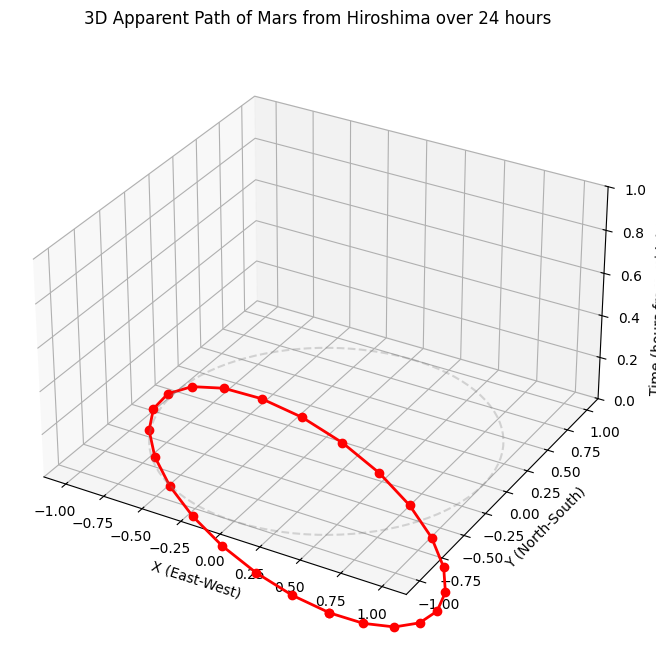

In [41]:
# 3Dグラフで火星の通り道を表してみる「いつどの方向にあるか」
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# データの計算（リセットする）
x = []
y = []
z = []

for alt, az in zip(alts, azs):
    #高度(alt)が0度以上の時に「空」にある
    #数学的な座標に変換する（球面座標系）ラジアンに変換
    alt_rad = np.radians(alt)
    az_rad = np.radians(az)

    #高さを出す
    z_val = np.sin(alt_rad) 

    # 横の広がりを出す
    r = np.cos(alt_rad)

    # X:東西、Y:南北 を出す
    x_val = r * np.sin(az_rad)
    y_val = r * np.cos(az_rad)

    # リストに追加
    x.append(x_val)
    y.append(y_val)
    z.append(z_val)

# 3Dグラフの描画
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')       

# 火星の通りをプロット
ax.plot(x, y, z, marker='o', linestyle='-', linewidth=2, color='red')

# 地平線を点線で描く
t = np.linspace(0, 2 * np.pi, 100)
ax.plot(np.sin(t), np.cos(t), 0, color='gray', alpha=0.3, linestyle='--')

# ドームらしくする
ax.set_box_aspect((1,1,0.6)) #縦を少しつぶす
ax.set_zlim(0,1) # 高度は0（地平線）～1（頭上）まで

# グラフの設定
ax.set_xlabel('X (East-West)')
ax.set_ylabel('Y (North-South)')
ax.set_zlabel('Altitude (0:Horizon to 1:Zenith)')

ax.set_zlabel('Time (hours from midnight JST)')
ax.set_title("3D Apparent Path of Mars from Hiroshima over 24 hours")
plt.show()

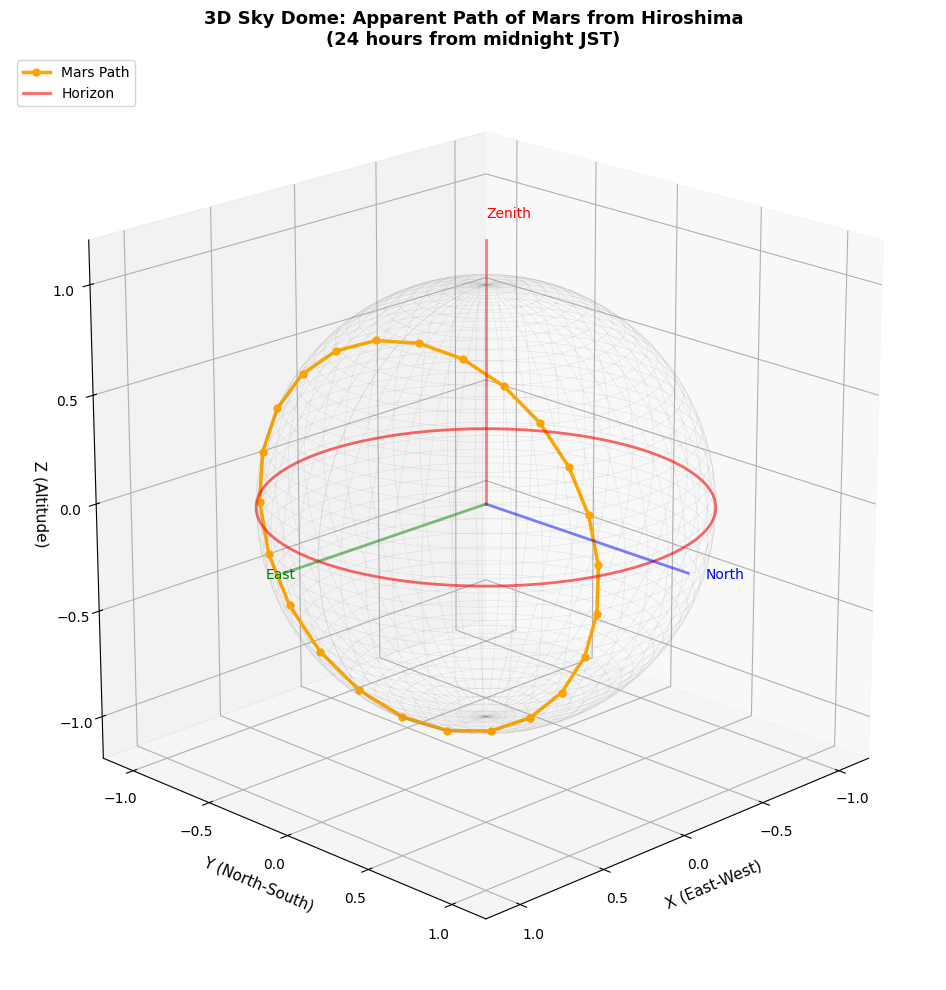

In [42]:
# 球体で火星の通り道を表してみる
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# データの計算（リセットする）
x = []
y = []
z = []

for alt, az in zip(alts, azs):
    # 数学的な座標に変換する（球面座標系）ラジアンに変換
    alt_rad = np.radians(alt)
    az_rad = np.radians(az)

    # 高さを出す
    z_val = np.sin(alt_rad) 

    # 横の広がりを出す
    r = np.cos(alt_rad)

    # X:東西、Y:南北 を出す
    x_val = r * np.sin(az_rad)
    y_val = r * np.cos(az_rad)

    # リストに追加
    x.append(x_val)
    y.append(y_val)
    z.append(z_val)

# 3Dグラフの描画
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 火星の通りをプロット
ax.plot(x, y, z, marker='o', linestyle='-', linewidth=2.5, color='orange', markersize=5, label='Mars Path')

"""
ここから球体のワイヤーフレームを追加
"""

# 球体のワイヤーフレームを作成
u = np.linspace(0, 2 * np.pi, 50)  # 経度
v = np.linspace(0, np.pi, 50)      # 緯度

# 球面座標
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

# 球体を描画（ワイヤーフレーム）
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='gray', alpha=0.15, linewidth=0.5)

# 地平線を描く 
theta = np.linspace(0, 2 * np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 0, color='red', linewidth=2, alpha=0.6, label='Horizon')

# 方位の参照線を追加 
# 北（Y軸）
ax.plot([0, 0], [0, 1.2], [0, 0], 'b-', linewidth=2, alpha=0.5)
ax.text(0, 1.3, 0, 'North', fontsize=10, color='blue')

# 東（X軸）
ax.plot([0, 1.2], [0, 0], [0, 0], 'g-', linewidth=2, alpha=0.5)
ax.text(1.3, 0, 0, 'East', fontsize=10, color='green')

# 天頂（Z軸）
ax.plot([0, 0], [0, 0], [0, 1.2], 'r-', linewidth=2, alpha=0.5)
ax.text(0, 0, 1.3, 'Zenith', fontsize=10, color='red')

# グラフの設定
ax.set_xlabel('X (East-West)', fontsize=11)
ax.set_ylabel('Y (North-South)', fontsize=11)
ax.set_zlabel('Z (Altitude)', fontsize=11)

# 軸の範囲を統一（球体に合わせる）
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_zlim(-1.2, 1.2)

# アスペクト比を等しくする
ax.set_box_aspect([1, 1, 1])

ax.set_title("3D Sky Dome: Apparent Path of Mars from Hiroshima\n(24 hours from midnight JST)", 
             fontsize=13, fontweight='bold')

ax.legend(loc='upper left')

# 視点を調整（見やすい角度）
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()
